In [13]:
#!pip install visualkeras

In [14]:
import tensorflow as tf
#from visualkeras import layered_view
prelu=tf.keras.layers.ReLU

In [15]:
def encoder_block(inputs, num_filters,dropout_rate,pen):
    x = tf.keras.layers.Conv2D(num_filters,3, padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(pen))(inputs)
    x = prelu()(x)
    x = tf.keras.layers.Conv2D(num_filters,3, padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(pen))(x)
    x = prelu()(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    p = tf.keras.layers.MaxPool2D(pool_size = (2,2))(x)
    return x,p

def decoder_block(inputs, skip_features, num_filters,dropout_rate,pen):
    # deconvolution
    x = tf.keras.layers.Conv2DTranspose(num_filters,(3,3),strides=(2,2), padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(pen))(inputs)
    x = tf.keras.layers.concatenate([x, skip_features])

    x = tf.keras.layers.Conv2D(num_filters,3, padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(pen))(x)
    x = prelu()(x)
    x = tf.keras.layers.Conv2D(num_filters,3, padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(pen))(x)
    x = prelu()(x)
    return x


def tower(inputs,num_filters,dropout_rate,pen):
    tower_1 = tf.keras.layers.Conv2D(num_filters, 3, padding='same',kernel_regularizer=tf.keras.regularizers.l2(pen))(inputs)
    tower_1=prelu()(tower_1)
    tower_1 = tf.keras.layers.MaxPooling2D(2, padding='same')(tower_1)

    tower_2 = tf.keras.layers.Conv2D(num_filters, 3, padding='same',kernel_regularizer=tf.keras.regularizers.l2(pen))(inputs)
    tower_2 = tf.keras.layers.MaxPooling2D(2, padding='same')(tower_2)

    merged=tf.keras.layers.concatenate([tower_1,tower_2])
    return merged

In [16]:
def unet_model(input_shape = (512, 512, 3), num_filters=256, num_classes = 10, dropout_rate=0.2,lam=0.001):
    inputs = tf.keras.layers.Input(input_shape)

    #       BLOCK 1
    #convolution with prelu
    c1 = tf.keras.layers.Conv2D(int(num_filters/32),3, padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(lam))(inputs)
    c1 = prelu()(c1)
    c1 = tf.keras.layers.MaxPool2D(2)(c1)
    c1=tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Dropout(rate=dropout_rate)(c1)
    #downsample - contracting path
    f1,p1=encoder_block(c1,int(num_filters/16),dropout_rate,lam)
    f2,p2=encoder_block(p1,int(num_filters/8),dropout_rate,lam)
    f3,p3=encoder_block(p2,int(num_filters/4),dropout_rate,lam)
    #bottleneck
    bottleneck = tf.keras.layers.Conv2D(int(num_filters/2), 3, padding = "same", kernel_regularizer=tf.keras.regularizers.l2(lam))(p3)
    bottleneck=prelu()(bottleneck)
    #upsample - expanding path
    u4 = decoder_block(bottleneck, f3, int(num_filters/4),dropout_rate,lam)
    u5 = decoder_block(u4, f2, int(num_filters/8),dropout_rate,lam)
    u6 = decoder_block(u5, f1, int(num_filters/16),dropout_rate,lam)

    #forward fine grained features with deconvolution
    features= tf.keras.layers.Conv2DTranspose(int(num_filters/32),3, padding = 'same',kernel_regularizer=tf.keras.regularizers.l2(lam))(u6)
    #parallel convolutions
    pc1=tower(features,int(num_filters/16),dropout_rate,lam)
    pc1 = tf.keras.layers.Dropout(rate=dropout_rate)(pc1)
    pc2=tower(pc1,int(num_filters/8),dropout_rate,lam)
    pc2 = tf.keras.layers.Dropout(rate=dropout_rate)(pc2)
    pc3=tower(pc2,int(num_filters/4),dropout_rate,lam)
    pc3 = tf.keras.layers.Dropout(rate=dropout_rate)(pc3)
    pc4=tower(pc3,int(num_filters/2),dropout_rate,lam)
    pc4 = tf.keras.layers.Dropout(rate=dropout_rate)(pc4)


    flat = tf.keras.layers.Flatten()(pc4)



    #       OUTPUT
    outputs = tf.keras.layers.Dense(num_classes, activation = "softmax")(flat)

    model = tf.keras.models.Model(inputs = inputs, outputs = outputs, name = 'U-Net')
    return model

## MODEL 1

In [17]:
#create model
model = unet_model(input_shape=(256, 256, 1),num_filters=512, num_classes=10)
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 256, 256,  │          0 │ conv2d_22[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ re_lu_18[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ max_pooling2d_12… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │      4,640 │ dropout_8[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 128, 128,  │          0 │ conv2d_23[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │      9,248 │ re_lu_19[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 128, 128,  │          0 │ conv2d_24[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ re_lu_20[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ dropout_9[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 64, 64,    │          0 │ conv2d_25[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │     36,928 │ re_lu_21[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_22 (ReLU)     │ (None, 64, 64,    │          0 │ conv2d_26[0][0] 

 Total params: 3,446,170 (13.15 MB)

 Trainable params: 3,445,690 (13.14 MB)

 Non-trainable params: 480 (1.88 KB)

In [18]:
#layered_view(model, legend = True)

In [19]:
#get dataset on colab
import requests
import os

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [20]:
from zipfile import ZipFile
#extract the dataset
with ZipFile(fname, 'r') as zipObj:
  zipObj.extractall()

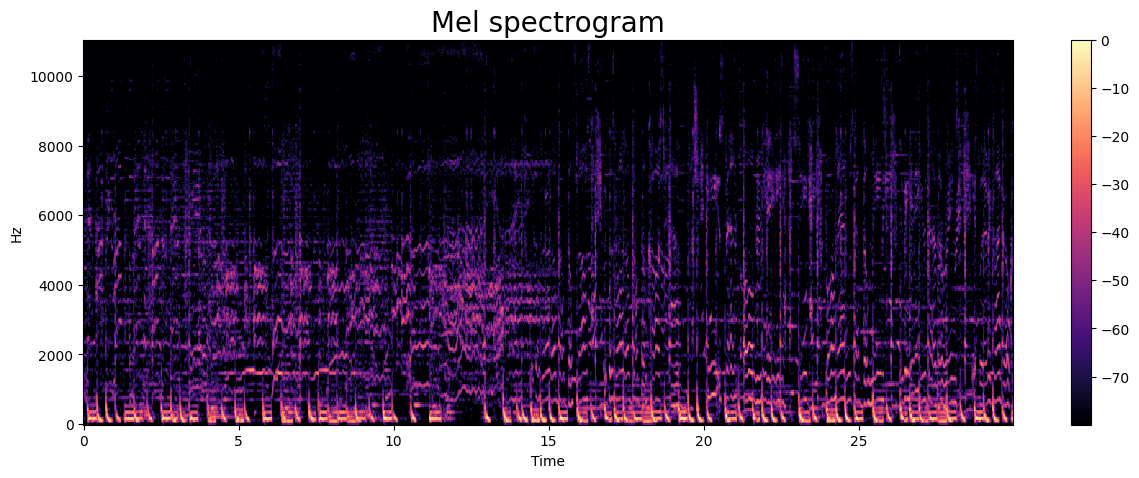

In [21]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

# Convert sound wave to mel spectrogram. trying this on a sample audio
sample_path = 'Data/genres_original/hiphop/hiphop.00031.wav'

y, sr = librosa.load(sample_path)

S = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=256)
S_DB = librosa.amplitude_to_db(S,ref=np.max)
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_DB, sr=sr,
                         x_axis='time', y_axis='linear')
plt.colorbar()
plt.title("Mel spectrogram", fontsize=20)
plt.show()

In [22]:
# Data Augmentation

'''
Noise addition using normal distribution with mean = 0 and std =1
Permissible noise factor value = x > 0.004
'''

def noise_addition(data,zero_value=0.0, noise_factor=0.1):
    noise = np.random.random(data.shape)
    augmented_data = data + noise_factor * noise
    #augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

'''
Time shifting the wave
Permissible factor values = sr/10
'''

def time_shift(data,zero_value=0.0):
    shift = np.random.randint(-3,4)*15
    augmented_data = np.roll(data, shift)
    return augmented_data

'''
Time-stretching the wave
Permissible factor values = 0 < x < 1.0
'''

def time_stretch(data,zero_value=0.0, speed_factor=2):
    samples = np.array_split(data, 3)
    data1=librosa.effects.time_stretch(samples[0], rate=1/speed_factor)
    data2=librosa.effects.time_stretch(samples[1], rate=speed_factor)
    data3=librosa.effects.time_stretch(samples[2], rate=speed_factor)
    return np.concatenate([data1,data2,data3])

'''
Pitch shifting of wav
Permissible factor values = -5 <= x <= 5
'''

def pitch_shift(data,zero_value=0.0,factor=4):
    return librosa.effects.pitch_shift(data, sr=22000, n_steps=factor)

#time mask
def time_mask(y,zero_value=0.0):
    zero_value=np.min(y)
    x=y.shape[1]
    step=12
    idxs=np.random.randint(0,x-step,size=(3))
    for idx in idxs:
        y[:,idx:idx+step]=zero_value
    return y

def frequency_mask(spec, zero_value=0.0):
    zero_value=np.min(spec)
    size=20
    idxs=np.random.randint(0,spec.shape[0]-10,size=2)
    for idx in idxs:
        spec[idx:idx+size,:]=zero_value
    return spec

'''
Augmenting the data
'''

def augment_data(data,zero_value=0.0,tresh=0.35):
    funs=[noise_addition,time_shift,time_mask,frequency_mask]
    for i in range(len(funs)):
        p=np.random.random()
        if p<tresh:
            data=funs[i](data,zero_value)
    return data

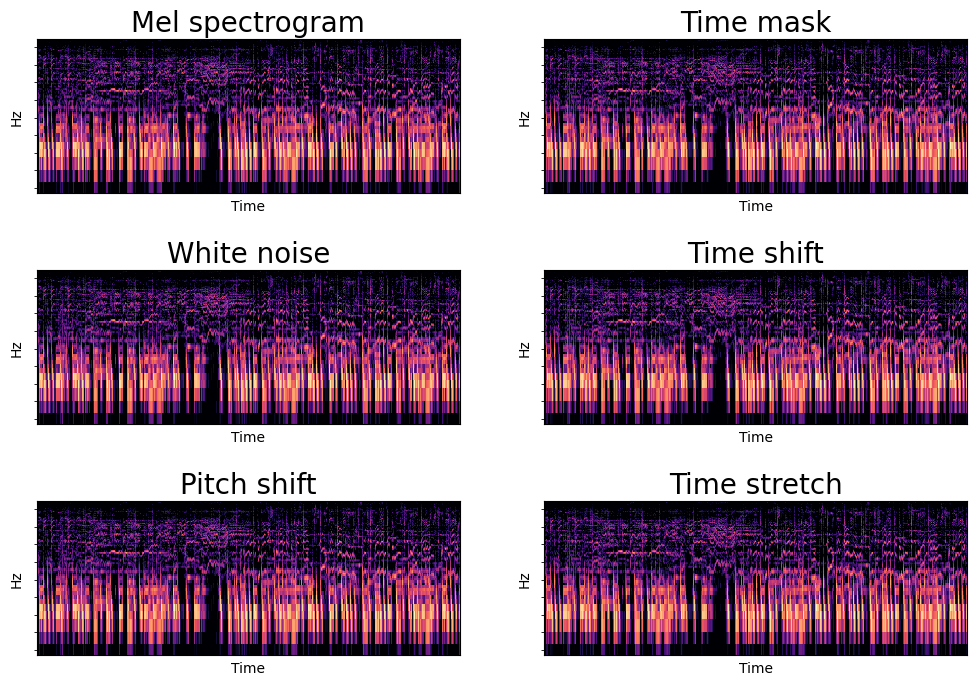

In [23]:
fig,axs=plt.subplots(3,2,figsize=(12,8))
axs=axs.flatten()
sample_path = 'Data/genres_original/hiphop/hiphop.00031.wav'
y,sr=librosa.load(sample_path)

#original
spec = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=256)
spec = librosa.amplitude_to_db(spec,ref=np.max)
axs[0].set_title("Mel spectrogram", fontsize=20)
librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log',ax=axs[0])

#time mask
# Fix: Ensure 'y' array has the expected dimensions for time_mask function
yhat=time_mask(y[np.newaxis, :])
spec = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=256)
spec = librosa.amplitude_to_db(spec,ref=np.max)
axs[1].set_title("Time mask", fontsize=20)
librosa.display.specshow(spec, sr=sr, hop_length=512, x_axis='time', y_axis='log', ax=axs[1])

#wn
yhat=noise_addition(y)
spec = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=256)
spec = librosa.amplitude_to_db(spec,ref=np.max)
axs[2].set_title("White noise", fontsize=20)
librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log',ax=axs[2])

#time shift
yhat=time_shift(y)
spec = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=256)
spec = librosa.amplitude_to_db(spec,ref=np.max)
axs[3].set_title("Time shift", fontsize=20)
librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log',ax=axs[3])

#pitch shift
yhat=pitch_shift(y)
spec = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=256)
spec = librosa.amplitude_to_db(spec,ref=np.max)
axs[4].set_title("Pitch shift", fontsize=20)
librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log',ax=axs[4])

#time stretch
yhat=time_stretch(y)
spec = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=256)
spec = librosa.amplitude_to_db(spec,ref=np.max)
axs[5].set_title("Time stretch", fontsize=20)
librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log',ax=axs[5])

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0.5)

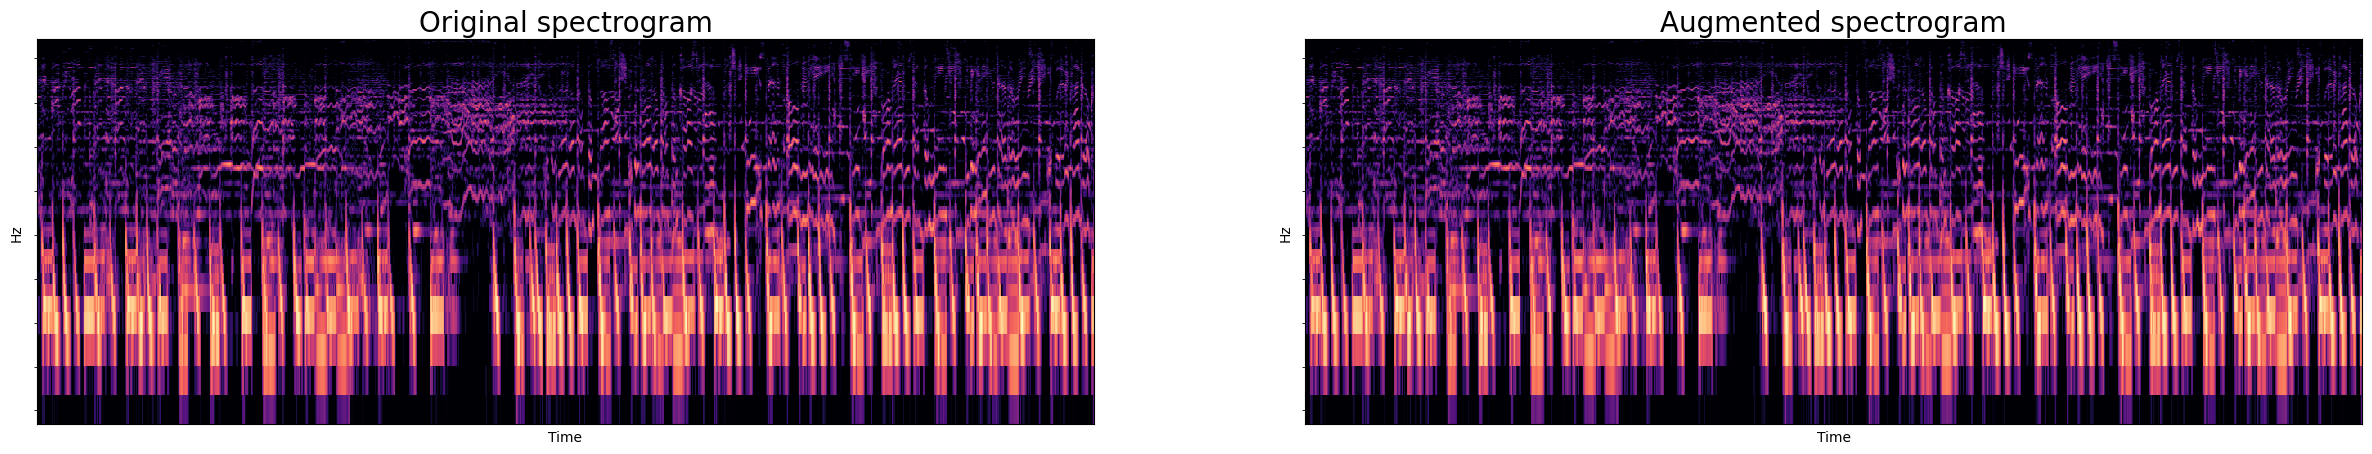

In [24]:
#randomly apply transformations
#run this block multiple times to see the different possibilities 
sample_path = 'Data/genres_original/hiphop/hiphop.00031.wav'
y,sr=librosa.load(sample_path)

fig,axs=plt.subplots(1,2,figsize=(30,5))

#augmented
yhat=augment_data(y)
spec = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=256)
spec = librosa.amplitude_to_db(spec,ref=np.max)
axs[1].set_title("Augmented spectrogram", fontsize=20)
librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log',ax=axs[1])

#original
axs[0].set_title("Original spectrogram", fontsize=20)
spec = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=256)
spec = librosa.amplitude_to_db(spec,ref=np.max)
librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log',ax=axs[0])

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [25]:
#testing with different audio samples,it is possible to see that the resulting
#spectrogram is not always the same size (the audios differ for some milliseconds)
#so, it is necessary to only consider the size 128x1290 (minimum size that all
#spectrograms have) and disregard other values to keep it consistent
print(S_DB.shape)
S_DB=S_DB[None,:,:1290,None]
S_DB.shape

(256, 1292)


(1, 256, 1290, 1)

In [26]:
#all genres within the dataset
data_path = 'Data/genres_original/'
genres = [folder for folder in os.listdir(data_path)]
genres

['pop',
 'metal',
 'disco',
 'blues',
 'reggae',
 'classical',
 'rock',
 'hiphop',
 'country',
 'jazz']

In [27]:
#corrupted audio
os.remove('Data/genres_original/jazz/jazz.00054.wav')

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#preprocessing function to get the spectrogram from the audio
def load_spec(y):
    specdb=librosa.feature.melspectrogram(y=y,sr=sr,n_mels=256)
    specdb = librosa.power_to_db(specdb,ref=np.max)
    specdb=specdb[:,:1280]
    return (specdb)


# data preparation
Xpy = []
y = []
data_path = 'Data/genres_original/'
genres = [folder for folder in os.listdir(data_path)]
for i, genre in enumerate(genres):
    genre_dir = os.path.join(data_path, genre)
    for filename in os.listdir(genre_dir):
        file_path = os.path.join(genre_dir, filename)
        audio, sr = librosa.load(file_path, sr=22050)
        Xpy.append(load_spec(audio))
        y.append(i)

X = np.array(Xpy)
y = np.array(y)
zeroval=0
#WE COULD TRY: data normalization
val_max=np.max(np.abs(X))
X=X/val_max
print(val_max)

# Split dataset into train and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train=[np.split(x,5,axis=1) for x in X_train]
X_train=np.array([piece for song in X_train for piece in song])
X_valid=np.array([np.split(x,5,axis=1) for x in X_valid])
X_valid=np.array([piece for song in X_valid for piece in song])
y_train=[[i,i,i,i,i] for i in y_train]
y_train=np.array([piece for song in y_train for piece in song])
y_valid=[[i,i,i,i,i] for i in y_valid]
y_valid=np.array([piece for song in y_valid for piece in song])
#shuffle the pieces
X_train,y_train=shuffle(X_train,y_train,random_state=7)

80.0


In [29]:
#check to see if training set is balanced
print([y_train[y_train==i].shape[0] for i in range(10)])

[400, 400, 400, 400, 400, 400, 400, 400, 400, 395]


In [30]:
#training with whole dataset causes colab to crash because of ram
#so we need to use a generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size,training=False):
        self.training=training
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.x_data))

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x = self.x_data[batch_indexes]
        specs=np.zeros((self.batch_size,256,256))
        for i in range(len(batch_x)):
            if self.training:
                batch_x[i]=augment_data(batch_x[i],zeroval)
            #spec = load_spec(batch_x[i])
            specs[i,:,:256] = batch_x[i] # Ensure the shape is (256,256)
        batch_y = self.y_data[batch_indexes]
        return specs[..., np.newaxis], batch_y  # Add a new dimension at the end

trainset = DataGenerator(X_train, y_train, batch_size=4,training=True)
validset = DataGenerator(X_valid, y_valid, batch_size=4)

In [31]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [32]:
history = model.fit(trainset, epochs=25, validation_data=validset)

Epoch 1/25


2024-05-29 17:20:35.430867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


697/999 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - accuracy: 0.1080 - loss: 4.2506

2024-05-29 17:22:08.887885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: logits and labels must have the same first dimension, got logits shape [4,10] and labels shape [3]
	 [[{{function_node __inference_one_step_on_data_12798}}{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]
2024-05-29 17:22:08.887905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: logits and labels must have the same first dimension, got logits shape [4,10] and labels shape [3]
	 [[{{function_node __inference_one_step_on_data_12798}}{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]
	 [[StatefulPartitionedCall/Cast_2/_368]]
2024-05-29 17:22:08.887913: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item ca

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/Applications/miniconda3/envs/NAML/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/br/7xh_tgxd7wn6ww3c5x1w_0pw0000gn/T/ipykernel_6604/2344339962.py", line 1, in <module>

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 329, in fit

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 122, in one_step_on_iterator

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 110, in one_step_on_data

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 323, in compute_loss

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 605, in __call__

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 641, in call

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/losses/loss.py", line 42, in __call__

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/losses/losses.py", line 22, in call

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/losses/losses.py", line 1714, in sparse_categorical_crossentropy

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/ops/nn.py", line 1567, in sparse_categorical_crossentropy

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 659, in sparse_categorical_crossentropy

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/Applications/miniconda3/envs/NAML/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/br/7xh_tgxd7wn6ww3c5x1w_0pw0000gn/T/ipykernel_6604/2344339962.py", line 1, in <module>

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 329, in fit

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 122, in one_step_on_iterator

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 110, in one_step_on_data

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 323, in compute_loss

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 605, in __call__

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 641, in call

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/losses/loss.py", line 42, in __call__

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/losses/losses.py", line 22, in call

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/losses/losses.py", line 1714, in sparse_categorical_crossentropy

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/ops/nn.py", line 1567, in sparse_categorical_crossentropy

  File "/Applications/miniconda3/envs/NAML/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 659, in sparse_categorical_crossentropy

2 root error(s) found.
  (0) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [4,10] and labels shape [3]
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]
	 [[StatefulPartitionedCall/Cast_2/_368]]
  (1) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [4,10] and labels shape [3]
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_13219]

In [ ]:
import json
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
#compute mean spectrograms for each genre
mean_spectrograms=[]
for i, genre in enumerate(genres):
    genre_dir = os.path.join(data_path, genre)
    genre_spectrograms=[]
    for filename in os.listdir(genre_dir):
        file_path = os.path.join(genre_dir, filename)
        audio = librosa.load_audio(file_path, target_shape=(512, 512))
        genre_spectrograms.append(audio)
    genre_spectrograms=np.array(genre_spectrograms)
    mean_spectrograms.append(np.mean(genre_spectrograms,axis=0))

In [ ]:
fig, axs = plt.subplots(ncols = 5, nrows = 2, figsize = (20,6))
axs = axs.reshape((-1,))

for i,genre in enumerate(genres):
  spec=np.reshape(mean_spectrograms[i],(128,1290))
  librosa.display.specshow(spec, sr=sr, hop_length=512,x_axis='time', y_axis='log', ax=axs[i])
  axs[i].set_title(genre, fontsize=16)
  #plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
#get prediction for all dataset
yhat_train=[]
truey_train=[]
yhat_valid=[]
truey_valid=[]
for i,song in enumerate(X_train):
  song = np.expand_dims(song, axis=0)
  song = np.expand_dims(song, axis=-1)
  res=np.argmax(model.predict(song))
  yhat_train.append(res)
  truey_train.append(y_train[i])

for i,song in enumerate(X_valid):
  song = np.expand_dims(song, axis=0)
  song = np.expand_dims(song, axis=-1)
  res=np.argmax(model.predict(song))
  yhat_valid.append(res)
  truey_valid.append(y_valid[i])

In [ ]:
#save results to file
truey_train=[int(x) for x in truey_train]
yhat_train=[int(x) for x in yhat_train]
with open('true_train.json','w') as f:
  json.dump(truey_train,f)
with open('predicted_train.json','w') as f:
  json.dump(yhat_train,f)

truey_valid=[int(x) for x in truey_valid]
yhat_valid=[int(x) for x in yhat_valid]
with open('true_valid.json','w') as f:
  json.dump(truey_valid,f)
with open('predicted_valid.json','w') as f:
  json.dump(yhat_valid,f)

In [ ]:
yhat_train

In [ ]:
import numpy as np
prova = np.ones((1,128,320))
model.predict(prova)